In [108]:
import matplotlib.pyplot as plt
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle
import random as rd
from sympy import *
import tensorflow as tf
import tensorflow_quantum as tfq
import math
from itertools import permutations, combinations, product

In [109]:
nqubits = 3

In [110]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    genbin(bit_count)
    return binary_strings

binary_strings = generate_binary_strings(nqubits)

In [111]:
with open('random_cnf.dimacs', 'r') as f:
    dimacs = f.read()
#print(dimacs)
unsat_list = []

for key in binary_strings:
    guess = [bool(int(x)) for x in key][::-1]

    clause_eval_list = []
    counter = 0
    for k, line in enumerate(dimacs.split('\n')):

        line = line.strip(' 0')
        clause_eval = False

        for literal in line.split(' '):
            if literal in ['p', 'c']:
                #line is not a clause
                clause_eval = True
                break
            if '-' in literal:
                literal = literal.strip('-')
                lit_eval = not guess[int(literal)-1]
            else:
                lit_eval = guess[int(literal)-1]
            clause_eval |= lit_eval
        #print(clause_eval)
        if k > 1:
            counter += 1
            clause_eval_list.append(clause_eval)
    unsat_clauses = counter - sum(clause_eval_list)
    unsat_list.append(unsat_clauses)

In [112]:
unsat_mat = np.diag(unsat_list)
unsat_mat

array([[3, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 2]])

In [113]:
"""Define a custom two-qubit gate."""
class BMgate(cirq.Gate):
    def __init__(self, beta, nqubits, mat):
        super(BMgate, self)
        self.beta = beta
        self.mat = mat
        self.qubits = nqubits
            
    def _num_qubits_(self):
        return nqubits

    def _unitary_(self):
        return np.exp(-1.0j * self.beta * self.mat)
    def _circuit_diagram_info_(self, args):
        return [f"U({self.beta})" for _ in range(nqubits)]

#this_gate = AnotherGate(beta = 0.5, nqubits = 5, mat = unsat_mat)

#cirq.unitary(this_gate)

In [114]:
qubits = []

for i in range(nqubits):
    qubits.append(cirq.GridQubit(0,i))        
    
qubits = list(qubits) #don't know why
all_qubits = [i for i in range(nqubits)]

In [115]:
def mixing_circuit(circuit, qubits, par):
    for i in range(len(qubits)):
        circuit.append(cirq.rx(par).on(qubits[i]))
    return circuit

In [116]:
nqubits

3

In [117]:
qubits = []

for i in range(nqubits):
    qubits.append(cirq.GridQubit(0,i))        
    
qubits = list(qubits) #don't know why
all_qubits = [i for i in range(nqubits)]
qubits

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2)]

In [118]:
qaoa_circuit = cirq.Circuit()

p = 2 #number of layers. When in doubt, stay on the lower side

num_param = 2 * p 
parameters = symbols("q0:%d" % num_param)

#setting up the layers
for i in range(p):
    #qaoa_circuit.append(BMgate(beta = parameters[2 * i], nqubits = nqubits, mat = unsat_mat).on(*qubits))
    for qubit in qubits:
        qaoa_circuit.append(cirq.rx(parameters[2 * i +1]).on(qubit))

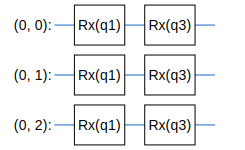

In [119]:
SVGCircuit(qaoa_circuit)

In [194]:
initial = cirq.Circuit()

for qubit in qubits:
    initial.append(cirq.H(qubit)) #applying Hadamard to all qubits before running circuit

#setting up the model
inputs = tfq.convert_to_tensor([initial])
ins = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.string)
outs = tfq.layers.PQC(qaoa_circuit, t1 + t2 + t3 +t4)(ins)
ksat = tf.keras.models.Model(inputs = ins, outputs = outs)
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)

#ksat.trainable_variables[0].assign([0.001 * rd.random() for i in range(2*p)]) #initializing angles with some small noise

In [191]:
def my_gate(c, index):
    g = c * cirq.Z(qubits[index]) + cirq.I(qubits[index])
    return g

In [192]:
from itertools import product

ones_list = list(product([-1,1], repeat=nqubits))
#ones_list

In [193]:
t1 = (0.5*math.prod([my_gate(1, i) for i in range(nqubits)]) + 0.5*math.prod([my_gate(-1, i) for i in range(nqubits)]))
t2 = (math.prod([my_gate(1, 0), my_gate(1, 1), my_gate(-1, 2)])+ math.prod([my_gate(-1, 0), my_gate(-1, 1), my_gate(1, 2)]))
t3 = (math.prod([my_gate(-1, 0), my_gate(1, 1), my_gate(-1, 2)])+ math.prod([my_gate(1, 0), my_gate(-1, 1), my_gate(1, 2)]))
t4 = (math.prod([my_gate(-1, 0), my_gate(1, 1), my_gate(1, 2)])+ math.prod([my_gate(1, 0), my_gate(-1, 1), my_gate(-1, 2)]))

(t1 + t2 + t3 +t4).matrix()

array([[4.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 8.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 8.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 8.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 8.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 8.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 8.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 4.+0.j]])